Постройте и визуализируйте структуру решающего дерева для критерия разбиения “entropy"

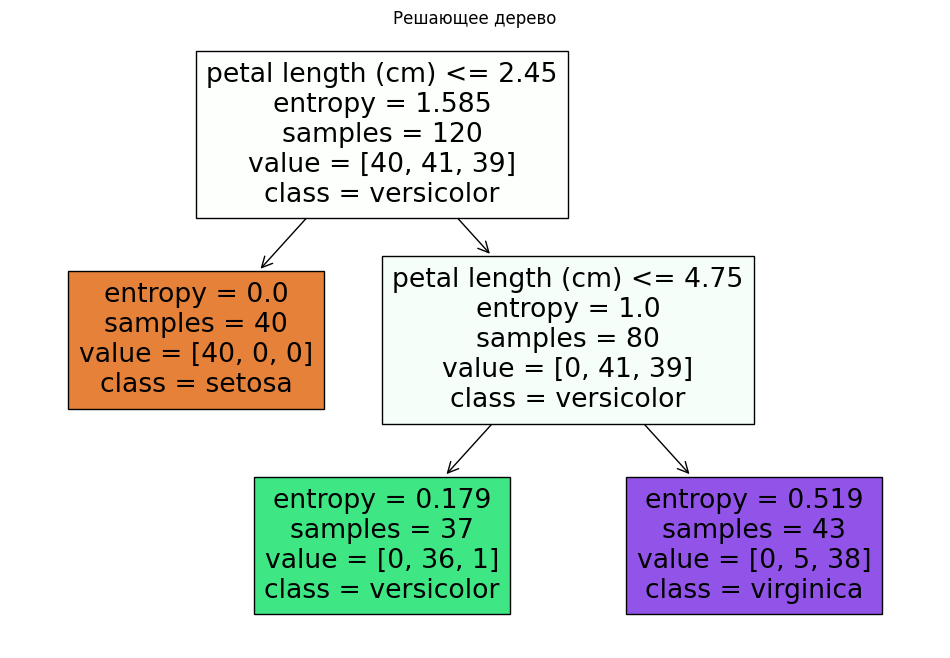

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
%matplotlib inline

iris = load_iris()
X = iris.data[:, 2:]   
y = iris.target
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Классификация с использованием дерева решений
tree_clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree_clf_entropy.fit(x_train, y_train)

# Визуализация дерева решений
# для критерия разбиения “entropy"
plt.figure(figsize=(12, 8))
tree.plot_tree(tree_clf_entropy, feature_names=iris.feature_names[2:], class_names=iris.target_names, filled=True)
plt.title("Решающее дерево")
plt.show()

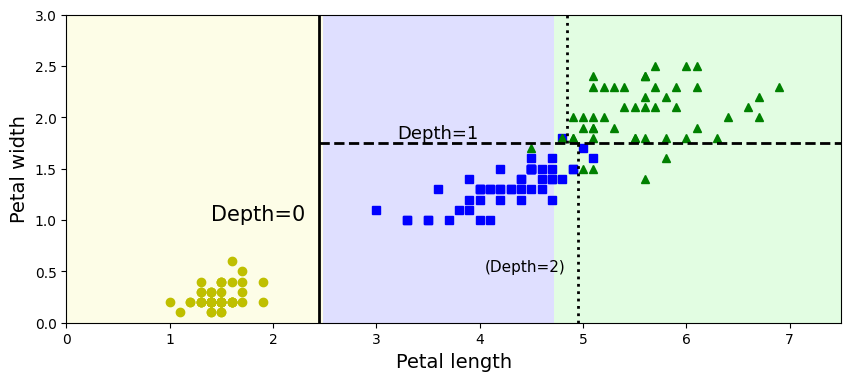

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(10, 4))
plot_decision_boundary(tree_clf_entropy, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

Обучите серию классификаторов без регуляризации по минимальному количеству экземпляров в листе.
визуализируйте MAE. Обучите дерево с наилучшими параметрами из предыдущего примера

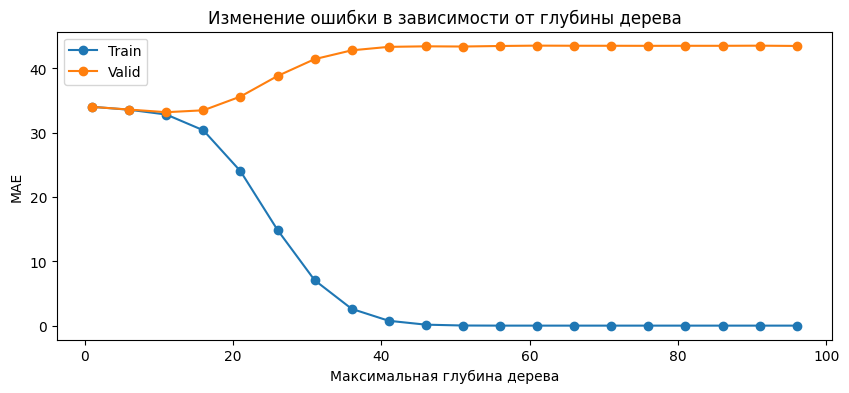

33.16906025036606

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

train = pd.read_csv('./train_features.csv').fillna(0)
y = pd.read_csv('./train_target.csv', index_col='id')
train.drop('Year', axis=1, inplace=True)

types = train.dtypes
real_cols = list(types[types != 'object'].index.values)

x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

dt = DecisionTreeRegressor()
dt.fit(x_train[real_cols], y_train)
mse_train = mean_absolute_error(dt.predict(x_train[real_cols]), y_train)
mse_val = mean_absolute_error(dt.predict(x_val[real_cols]), y_val)

mse_train = []
mse_val = []

for i in range(20):
    dt = DecisionTreeRegressor(max_depth=i*5+1)
    dt.fit(x_train[real_cols], y_train)
    mse_train = np.append(mse_train, mean_absolute_error(dt.predict(x_train[real_cols]), y_train))
    mse_val = np.append(mse_val, mean_absolute_error(dt.predict(x_val[real_cols]), y_val))

plt.figure(figsize=(10, 4))
plt.title('Изменение ошибки в зависимости от глубины дерева')

plt.plot([i*5 + 1 for i in range(20)], mse_train, label='Train', marker='o')
plt.plot([i*5 + 1 for i in range(20)], mse_val, label='Valid', marker='o')
plt.legend()
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('MAE')
plt.show()

best_dt = DecisionTreeRegressor(max_depth=11)
best_dt.fit(x_train[real_cols], y_train)
mean_absolute_error(best_dt.predict(x_val[real_cols]), y_val)

Выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor. Выбрать оптимальные параметры для каждого дерева.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

bag_of_trees = BaggingRegressor(estimator=best_dt, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(bag_of_trees, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train[real_cols], y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE: {grid_search.best_score_}')

c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:505: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Лучшие параметры: {'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 8}
Лучший MAE: -33.04247346729184


Обучить, выявить оптимальное количество моделей в регрессоре, оптимальные параметры для регрессора

In [16]:
param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(forest, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train[real_cols], y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE на валидационной выборке: {grid_search.best_score_}')

c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
48 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-package

Лучшие параметры: {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 8}
Лучший MAE на валидационной выборке: -33.39800170180205
